# Module 3 - Shrinking Kernel Deconvolution

High-order SOFI provides is an estimation of the point spread function (PSF) of the optical system. With the information of PSF, we can use [deconvolution](https://en.wikipedia.org/wiki/Deconvolution) to solve the inverse problem and obtain the ground truth image. 

In SOFI 2.0, a consecutive [Richard-Lucy deconvolution](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution) with a series of 2D Gaussian kernels ([shrinking kernel deconvolution](https://escholarship.org/content/qt5xs5v4qm/qt5xs5v4qm.pdf?t=oniulr)) is applied on each frame of the noise filtered moment-reconstructions to further enhance the spatial resolution by a factor of $\sqrt{n}$. 

This notebook demonstrates how to achieve better resolution enhancement with shrinking kernel deconvoluiton using **pysofi**. 

## 1. Load data into Data object.

The input data can be videos (tiff image stacks) from simulations or fluorescence imaging experiements. In this notebook, we use data from Hela cells transfected with Dronpa-C12 (fluorescent protein) fused to β-Actin. Live cells were imaged with 30 ms frame integration and 200 frames in total.

The input data is first loaded into the Data object, and method <code>average_image()</code> is used to get the average image of the video.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import data, masks
%matplotlib inline

# load data into Data object
filepath = '../sampledata'
filename = 'Block10.tif'
d = data.Data(filepath, filename)

Loading BokehJS ...

## 2. Shrinking kernel deconvolution.

The idea of shrinking kernel deconvolution is that the deconvolution kernel (2D Gaussian) can be decomposed into a series of narrower Gaussian kernels. For a Gaussian kernel $U$, 

$ U^{\frac{\lambda}{\lambda-1}}*U^{\frac{\lambda^2}{\lambda-1}}*\cdots*U^{\frac{\lambda^n}{\lambda-1}}\propto U $.

In this way, each individual deconvolution step is a lighter task, because the target is more similar to the input image. 

<code>d.deconvsk</code> is a method of the Data object that apply shrinking dernel deconvolution on the given data. We can pass
+ <code>est_psf</code>: the estimation of the PSF, which can be obtained from the simulation, optical set-up measurement or calculation.
+ <code>input_im</code>: input image that needs deconvolution, which can be a random frame, average image or moment-/cumulant- reconstructed image.
+ <code>deconv_lambda</code>: $\lambda$ exponent for the equation above. It is an empirical parameter between 1 and 2. 
+ <code>deconv_iter</code>: number of iterations.

We can generate a two-dimensional Gaussian mask with a defined shape using <code>masks.gauss2D_mask(kernal_size, sigma)</code>. This mask is the original PSF estimation. In this notebook, we use the average image as the input image, but the user has multiple options for the input, e.g., a random frame, the moment- or cumulant- reconstructed image.

In [2]:
deconv_psf = masks.gauss2d_mask((51, 51), 2)
deconv_psf = deconv_psf / np.max(deconv_psf)
deconv_lambda = 1.5
deconv_iter = 20

deconv_im = d.deconvsk(deconv_psf, d.average_image(), deconv_lambda, deconv_iter)

[=================== ] 100%

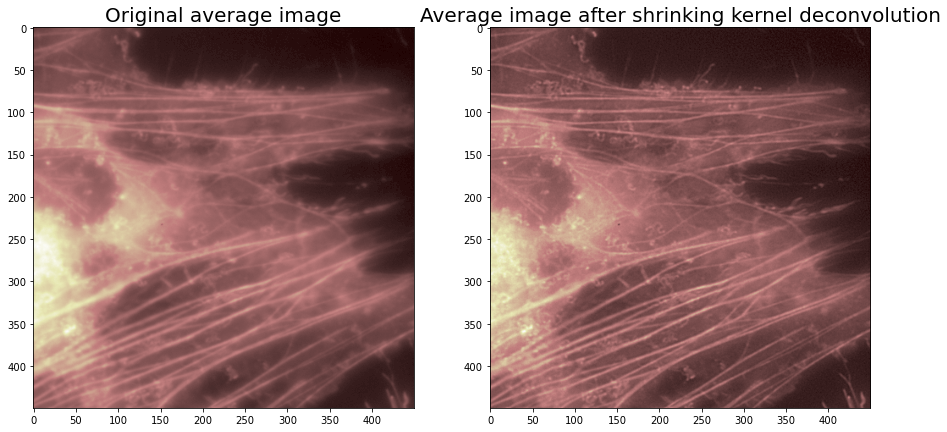

In [3]:
# show average image before and after the deconvolution
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].set_title('Original average image', fontsize=20)
axs[0].imshow(d.ave, cmap='pink')
axs[1].set_title('Average image after shrinking kernel deconvolution', fontsize=20)
axs[1].imshow(deconv_im, cmap='pink')
plt.show()

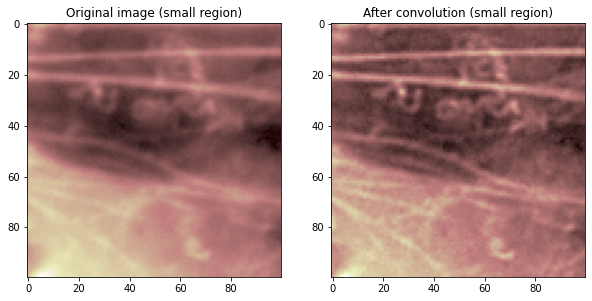

In [4]:
# Zoom into a small area
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image (small region)')
axs[0].imshow(d.ave[100:200, 100:200], cmap='pink')

axs[1].set_title('After convolution (small region)')
axs[1].imshow(deconv_im[100:200, 100:200], cmap='pink')
plt.show() 

As we can see from figures above, shrinking kernel deconvolution can restore details of β-Actin filaments, and increase the resolution efficiently. Multiple filaments that are close-by and hard to resolve in the original image can be cleared resolved after the deconvolution step.